# 개요

* PyTorch를 사용하여 딥러닝 모델을 개발하고 훈련하는 과정에서 발생할 수 있는 다양한 에러 상황을 이해하고,
* 이를 어떻게 해결할 수 있는지에 알아보기
* 특히, Custom Dataset과 Custom Model 구현, 그리고 학습 및 평가 시에 자주 발생하는 에러 상황을 중점적으로 다룸

#### 목표

- Custom Dataset과 Custom Model을 구현하는 과정에서 발생하는 주요 에러를 이해하고 이를 해결할 수 있다.
- CUDA 메모리 문제를 이해하고, 이를 해결하는 방법을 배울 수 있다.
- 모델 학습 및 평가 시에 발생하는 다양한 에러 상황과 이를 해결하는 방법을 배울 수 있다.

##### 실습에서 다루지 않은 에러가 발생한다면?

1. 에러 메세지를 자세히 읽어보는 것은 매우 중요 : Python과 PyTorch는 보통 어디에서 왜 에러가 발생했는지를 나타내는 메세지를 제공합니다.
2. 구글에 키워드 기반으로 검색 : 거의 대부분의 에러는 다른 개발자들도 이미 접했고, 이런 문제를 해결하는 많은 정보를 인터넷을 통해 공유했습니다.

# 환경설정

In [ ]:
!pip install torch==2.0.1 -q
!pip install torchtext==0.15.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# !pip install torch
# !pip install torchtext

In [ ]:
import numpy as np # 기본적인 연산을 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리

from torchtext.data import get_tokenizer # torch에서 tokenizer를 얻기 위한 라이브러리
import torchtext # torch에서 text를 더 잘 처리하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 성능지표 측정
from sklearn.model_selection import train_test_split # train-validation-test set 나누는 라이브러리

import re # text 전처리를 위한 라이브러리
import pandas as pd # 테이블 데이터를 편리하게 처리하기 위한 라이브러리

In [ ]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

## 데이터셋 개요

데이터 셋 개요 </b>

* 데이터셋: <a href='https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset'>Medium Dataset</a>
* 데이터셋 개요: "Towards Data Science", "UX Collective", "The Startup", "The Writing Cooperative", "Data Driven Investor", "Better Humans", "Better Marketing" 의 7개의 주제를 가지는 publication 에 대해서 크롤링을 한 데이터입니다. 원본 데이터는 총 6,508개의 블로그 이미지와 메타 데이터(.csv)로 구성됩니다. 실습에서는 메타데이터를 사용하여 CustomDataset을 구현합니다.
  * [How to collect ths dataset?](https://dorianlazar.medium.com/scraping-medium-with-python-beautiful-soup-3314f898bbf5)
- 메타 데이터 스키마: 메타 데이터는 총 **10**개의 column으로 구성됩니다.
  - id: 아이디
  - url: 포스팅 링크
  - title: 제목
  - subtitle: 부제목
  - image: 포스팅 이미지의 파일 이름
  - claps: 추천 수
  - reponses: 댓글 수
  - reading_time: 읽는데 걸리는 시간
  - publication: 주제 카테고리(e.g. Towards Data Science..)
  - date: 작성 날짜
- 데이터 셋 저작권: CC0: Public Domain



# 1.Custom Dataset 구현 시 에러

In [ ]:
# !pip install kaggle

In [ ]:
from google.colab import files

# Kaggle API 키 파일 업로드
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dorianlazar/medium-articles-dataset

Dataset URL: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset
License(s): CC0-1.0
100% 1.33G/1.33G [00:34<00:00, 45.2MB/s]
100% 1.33G/1.33G [00:34<00:00, 41.3MB/s]


In [ ]:
# 다운로드한 파일 확인
!ls

medium-articles-dataset.zip  sample_data


In [ ]:
# 압축 파일 해제

!unzip medium-articles-dataset.zip -d medium-articles-dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: medium-articles-dataset/images/2249.jpeg  
  inflating: medium-articles-dataset/images/225.png  
  inflating: medium-articles-dataset/images/2250.jpeg  
  inflating: medium-articles-dataset/images/2251.jpg  
  inflating: medium-articles-dataset/images/2252.jpeg  
  inflating: medium-articles-dataset/images/2253.jpeg  
  inflating: medium-articles-dataset/images/2254.jpg  
  inflating: medium-articles-dataset/images/2255.jpg  
  inflating: medium-articles-dataset/images/2256.png  
  inflating: medium-articles-dataset/images/2257.jpeg  
  inflating: medium-articles-dataset/images/2258.jpeg  
  inflating: medium-articles-dataset/images/2259.jpg  
  inflating: medium-articles-dataset/images/226.jpeg  
  inflating: medium-articles-dataset/images/2260.jpeg  
  inflating: medium-articles-dataset/images/2261.jpeg  
  inflating: medium-articles-dataset/images/2262.jpg  
  inflating: medium-articles-dataset/images/2263.jpg  
  inflating: medium-ar

In [ ]:
# # google drive mount
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive

In [ ]:
data_csv = pd.read_csv('/content/medium-articles-dataset/medium_data.csv')

# train set과 validation set, test set을 각각 나눕니다. 8 : 1 : 1 의 비율로 나눕니다.
train_csv, test_csv = train_test_split(data_csv, test_size = .2, random_state = 42)
val_csv, test_csv = train_test_split(test_csv, test_size = .5, random_state = 42)

# index 를 reset 해줍니다.
train_csv = train_csv.reset_index(drop=True)
val_csv = val_csv.reset_index(drop=True)
test_csv = test_csv.reset_index(drop=True)

print("Train 개수: ", len(train_csv))
print("Validation 개수: ", len(val_csv))
print("Test 개수: ", len(test_csv))

# 각각의 title만 추출합니다.
# 우리는 title의 첫 단어가 주어졌을 떄, 다음 단어를 예측하는 것을 수행할 것입니다.
data = data_csv['title'].values
train = train_csv['title'].values
val = val_csv['title'].values
test = test_csv['title'].values

Train 개수:  5206
Validation 개수:  651
Test 개수:  651


## `__len__` 메서드에서의 에러
Custom Dataset을 구현하며 `__len__` 메서드에서는 필수적으로 데이터의 총 개수를 반환해야 합니다. 하드 코딩을 한다면 코드의 재사용성이 낮아지게 됩니다.

아래 코드에서는 `__len__` 메서드에서 반환하는 값을 총 개수가 아닌 숫자 값으로 작성했습니다.

- `__len__` 반환 값이 데이터 수보다 적은 경우: 데이터 로더에서 반환하는 값만큼의 데이터를 사용하게 돼 모든 데이터를 사용하지 못합니다.
- `__len__` 반환 값이 데이터 수보다 많은 경우: 현재 가진 데이터의 최대 index보다 큰 값을 데이터 로더가 불러올 경우, 해당 index의 데이터를 찾지 못해 IndexError가 발생합니다.


구글 검색 키워드: `pytorch custom dataset 인덱스 에러`

### IndexError : 반환 값이 잘못된 경우

In [ ]:
def cleaning_text(text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text)
    cleaned_text = cleaned_text.replace(u'\xa0',u' ')
    cleaned_text = cleaned_text.replace('\u200a',' ')
    return cleaned_text

def make_word_dic(data, tokenizer):
    cleaned_data = map(cleaning_text, data)
    vocab = torchtext.vocab.build_vocab_from_iterator(map(tokenizer, cleaned_data))
    vocab.insert_token('<pad>',0)
    word_to_id = dict(sorted(vocab.get_stoi().items(), key=lambda item: item[1]))
    return word_to_id

In [ ]:
# Medium 데이터를 사용하여 Custom Dataset을 구축합니다.
# 아래의 코드는 __len__ 메서드 반환 값이 잘못된 경우입니다.
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
    self.X = torch.tensor(self.seq[:,:-1])
    self.label = torch.tensor(self.seq[:,-1])

  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])

# 수정된 부분 --------------------------------------------------
  def __len__(self): # dataset의 전체 길이 반환
    return 50000  # len(self.X) : Train 개수 5206 보다 훨씬 큼
# --------------------------------------------------------------

  def __getitem__(self, idx): # dataset 접근
    X = self.X[idx]
    label = self.label[idx]

    return X, label

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

IndexError: index 39021 is out of bounds for dimension 0 with size 39021

In [ ]:
# Medium 데이터를 사용하여 Custom Dataset을 구축합니다.
# 아래의 코드는 __len__ 메서드 반환 값이 잘못된 경우를 다시 수정한 경우입니다.
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
    self.X = torch.tensor(self.seq[:,:-1])
    self.label = torch.tensor(self.seq[:,-1])

  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])

# 다시 올바르게 수정 ----------------------------
  def __len__(self): # dataset의 전체 길이 반환
    return len(self.X)
# -----------------------------------------------

  def __getitem__(self, idx): # dataset 접근
    X = self.X[idx]
    label = self.label[idx]

    return X, label

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

## `__getitem__` 메서드에서의 에러
위의 에러 상황과 같은 맥락으로 Custom Dataset 구현 시 IndexError는 자주 발생하는 에러 중 하나입니다. `__getitem__` 메서드 작성 시에도 주어진 데이터 수보다 초과하는 인덱스에 접근한다면, IndexError가 발생합니다.


### IndexError : 잘못 접근한 경우

In [ ]:
# 아래의 코드는 __getitem__ 메서드에서 index를 잘못 접근한 경우입니다.
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
    self.X = torch.tensor(self.seq[:,:-1])
    self.label = torch.tensor(self.seq[:,-1])

  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])

  def __len__(self): # dataset의 전체 길이 반환
    return len(self.X)

# 수정된 부분 ----------------------------------------------------------------------------------------------------------
  def __getitem__(self, idx): # dataset 접근
    # 전처리된 데이터(self.X)가 아닌 원시 데이터(self.data)에 접근하는 상황을 가정합니다.

    X = self.data[idx] # X = self.X[idx] : DataLoader에서 인자로 주는 idx보다 self.data의 크기가 작기 때문에 에러 발생
    label = self.label[idx]

    return X, label
# -----------------------------------------------------------------------------------------------------------------------

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

IndexError: list index out of range

In [ ]:
# 올바르게 수정된 코드
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
    self.X = torch.tensor(self.seq[:,:-1])
    self.label = torch.tensor(self.seq[:,-1])


  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])


  def __len__(self): # dataset의 전체 길이 반환
    return len(self.X)

# 수정된 부분 --------------------------------------
  def __getitem__(self, idx): # dataset 접근
    X = self.X[idx]
    label = self.label[idx]

    return X, label
# --------------------------------------------------

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

### RuntimeError : 데이터 타입을 제대로 반환하지 않은 경우

`__getitem__`에서 데이터 타입을 제대로 변환하지 않은 경우

TypeError는 PyTorch의 특정 레이어나 함수에서 요구하는 데이터 타입과 입력 데이터의 타입이 일치 하지 않을 때 주로 발생합니다.
예를 들어 `nn.Embedding` 레이어는 입력으로 long 타입의 tensor를 요구하는데, float 타입의 tensor를 입력하면 type 문제로 인한 `RuntimeError`가 발생합니다.


구글 검색 키워드: nn.Embedding Runtime Error

In [ ]:
# float 타입의 데이터를 반환하는 Dataset
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌

    """
    데이터를 처리하는 과정에서 데이터 타입이 맞지 않는 경우(e.g. Embedding Layer를 통과하는 데 사용되는 데이터가 torch.float인 경우)
    """
    self.X = self.seq[:,:-1].astype(float) # float 타입의 numpy array
    self.label = self.seq[:,-1].astype(float)

  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])

  def __len__(self): # dataset의 전체 길이 반환
    return len(self.X)

# 수정된 부분 --------------------------------------
  def __getitem__(self, idx): # dataset 접근
    # numpy array 타입의 데이터를 tensor로 변환
    X = torch.tensor(self.X[idx])   # Long 또는 Int 타입이 들어와야 하는데, 더블 타입이 들어왔다.
    # X = torch.tensor(self.X[idx], dtype = torch.long)
    label = torch.tensor(self.label[idx])
    # label = torch.tensor(self.label[idx], dtype = torch.long)

    return X, label
# --------------------------------------------------

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

layer = nn.Embedding(len(word_to_id), 128)
out = layer(text)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.DoubleTensor instead (while checking arguments for embedding)

In [ ]:
# 올바르게 수정된 코드
class CustomDataset(Dataset):
  def __init__(self, data, word_to_id, tokenizer, max_len):
    self.data = list(map(self.cleaning_text, data))
    self.word_to_id = word_to_id # 단어 사전 불러오기
    self.max_len = max_len
    self.tokenizer = tokenizer
    seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
    self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌

    """
    데이터를 처리하는 과정에서 데이터 타입이 맞지 않는 경우(e.g. Embedding Layer를 통과하는 데 사용되는 데이터가 torch.float인 경우)
    아래의 실습 예시에서는 __getitem__에서 torch.long 데이터 타입으로 변경
    """
    self.X = self.seq[:,:-1].astype(float)
    self.label = self.seq[:,-1].astype(float)


  def cleaning_text(self, text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
    cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
    cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
    return cleaned_text

  def make_sequence(self, data, word_to_id, tokenizer):
    seq = []
    for i in data:
      token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
      for j in range(1, len(token_id)):
        sequence = token_id[:j+1]
        seq.append(sequence)
    return seq

  def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
    return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])


  def __len__(self): # dataset의 전체 길이 반환
    return len(self.X)

  def __getitem__(self, idx): # dataset 접근
    X = torch.tensor(self.X[idx], dtype = torch.long)
    label = torch.tensor(self.label[idx], dtype = torch.long)

    return X, label

batch_size = 32
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 37
train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, drop_last = False)

for text, labels in train_dataloader:
  pass

layer = nn.Embedding(len(word_to_id), 128)
out = layer(text)

## Dimension Error

일반적으로 PyTorch에서 CNN 레이어는 입력 데이터의 차원을 B $\times$ C $\times$ H $\times$ W(B: 미니 배치 크기, C: 채널 수, H: 높이, W: 너비)로 입력 받습니다.(배치가 아닌 경우, C $\times$ H $\times$ W도 가능합니다.) 만약 이 차원과 일치하지 않는 데이터를 입력한다면, `Dimension Error`가 발생합니다.


구글 검색 키워드: 에러 메세지


### RuntimeError : 입력 tensor의 차원이 맞지 않는 경우

3D 나 4D input을 받아야 하는데, 2D input을 받았다.

In [ ]:
# 입력 tensor의 차원이 맞지 않는 경우
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
inputs = torch.randn(28, 28)  # 차원이 HxW, input 채널을 1로 줬는데, 채널 자체가 존재하지 않음
out = conv(inputs)  # 에러 발생: expected 4D input (got 3D input)
out.shape

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [28, 28]

In [ ]:
# 올바르게 구현된 코드
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
inputs_3d = torch.randn(1, 28, 28)  # 차원이 CxHxW
out = conv(inputs_3d)  # 에러 발생: expected 4D input (got 3D input)

inputs_4d = torch.randn(1, 1, 28, 28)  # 차원이 BxCxHxW
out = conv(inputs_4d)

# 2.Custom Model 구현 시 에러

## Dimension mismatch error

mismatch error는 네트워크의 한 layer에서 다음 layer로 데이터를 전달할 때 입력 데이터의 차원과 계층이 기대하는 차원이 일치하지 않을 때 발생합니다. 주로 잘못된 계층 구성 또는 데이터 전처리로 인해 발생합니다.


구글 검색 키워드: 에러 메세지

### RuntimeError : mismath

In [ ]:
# mistmath error가 발생하는 코드
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_ratio):
        super(CNN,self).__init__()
        self.num_classes = num_classes

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # [1,28,28] -> [16,24,24]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # [16,24,24] -> [32,20,20]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.MaxPool2d(kernel_size=2), # [32,20,20] -> [32,10,10]
            nn.Dropout(dropout_ratio),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # [32,10,10] -> [64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 크기를 1/2로 줄입니다. [64,6,6] -> [64,3,3]
            nn.Dropout(dropout_ratio),
        )

# 수정된 부분 -------------------------------------------------------------------------------------------------------
        self.fc_layer = nn.Linear(64*5*5, self.num_classes) # [64*3*3] 차원을 입력으로 받아야 하나, 잘못된 입력 구성
        self.softmax = nn.LogSoftmax(dim = 1)
# -------------------------------------------------------------------------------------------------------------------

    def forward(self,x):
        """
        Input and Output Summary

        Input:
          x: [batch_size, 1, 28, 28]
        Output:
          output: [batch_size, num_classes]

        """
        out = self.layer(x) # [batch_size, 64, 3, 3]
        out = out.view(x.shape[0], -1) # [batch_size, 64, 576]
        pred = self.fc_layer(out) # mis-match
        pred = self.softmax(pred)

        return pred

model = CNN(num_classes = 10, dropout_ratio = 0.2)
input = torch.randn(1, 1, 28, 28)
output = model(input)  # this will cause RuntimeError

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x576 and 1600x10)

> nn.Linear 모듈을 여러개 사용할 경우, 아래 반복문을 통해서 확인

In [ ]:
# fully connected layer에서 mismatch error가 발생할 경우, 아래의 반복문을 통해 어떤 레이어에서 에러 메세지가 발생했는지 비교하여 확인할 수 있습니다.
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear):
        print(f"Layer {name}: {layer.in_features} -> {layer.out_features}")

Layer fc_layer: 1600 -> 10


In [ ]:
# 올바르게 구현된 코드
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_ratio):
        super(CNN,self).__init__()
        self.num_classes = num_classes

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # [1,28,28] -> [16,24,24]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # [16,24,24] -> [32,20,20]
            nn.ReLU(),  # ReLU 활성화 함수 적용
            nn.MaxPool2d(kernel_size=2), # [32,20,20] -> [32,10,10]
            nn.Dropout(dropout_ratio),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # [32,10,10] -> [64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 크기를 1/2로 줄입니다. [64,6,6] -> [64,3,3]
            nn.Dropout(dropout_ratio),
        )

        self.fc_layer = nn.Linear(64*3*3, self.num_classes) # [64*3*3]
        self.softmax = nn.LogSoftmax(dim = 1)


    def forward(self,x):
        """
        Input and Output Summary

        Input:
          x: [batch_size, 1, 28, 28]
        Output:
          output: [batch_size, num_classes]

        """
        out = self.layer(x) # [batch_size, 64, 3, 3]
        out = out.view(x.shape[0], -1) # [batch_size, 576]
        pred = self.fc_layer(out) # [batch_size, 10]
        pred = self.softmax(pred) # [batch_size, 10]

        return pred

model = CNN(num_classes = 10, dropout_ratio = 0.2)
input = torch.randn(1, 1, 28, 28)
output = model(input)

## Tensor manipulation

Dimension mismath error와 같은 맥락으로 특정 레이어 통과 후 데이터의 차원을 고려하여 적절하게 조작해줘야 하는 경우가 많습니다. 예시로 Global Average Pooling을 사용하면 B $\times$ C $\times$ H $\times$ W의 입력 tensor는 B $\times$ C $\times$ 1 $\times$ 1로 변환 됩니다.

이 경우, 다음 layer인 fully connected layer와 연산하기 위해서는 적절하게 tensor의 차원을 조작해줘야 합니다. 그렇지 않을 경우 dimension mismatch error가 발생합니다.

### RuntimeError : shape이 다를 경우

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size=5)
        self.gap = nn.AdaptiveAvgPool2d(1) # 1x1 Global Average Pooling
        self.fc = nn.Linear(10, 10)

    def forward(self, x):
        """
        Input and Output Summary

        Input:
          x: [batch_size, 1, 28, 28]
        Output:
          output: [batch_size, 10]

        """
        x = self.conv(x) # [batch_size, 10, 24, 24]
        x = self.gap(x) # [batch_size, 10, 1, 1]
# 수정된 부분 ---------------------------------------------------------------------------
        # x = x.view(x.size(0), -1) view를 사용하지 않아 4 dimension이 계속 유지되는 경우
        # mis-match
        x = self.fc(x)
        return x
# ---------------------------------------------------------------------------------------

net = Model()
input = torch.randn(1, 1, 28, 28)
output = net(input)  # This will cause RuntimeError due to mismatch in dimension


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x1 and 10x10)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size=5)
        self.gap = nn.AdaptiveAvgPool2d(1) # 1x1 Global Average Pooling
        self.fc = nn.Linear(10, 10)

    def forward(self, x):
        """
        Input and Output Summary

        Input:
          x: [batch_size, 1, 28, 28]
        Output:
          output: [batch_size, 10]

        """
        x = self.conv(x) # [batch_size, 10, 24, 24]
        x = self.gap(x) # [batch_size, 10, 1, 1]

        x = x.view(x.size(0), -1) # [batch_size, 10]
        x = self.fc(x) # [batch_size, 10]
        return x

net = Model()
input = torch.randn(1, 1, 28, 28)
output = net(input)


# 3.학습 및 평가 시 에러

## CUDA RAM out of memory

GPU의 메모리는 한정적이기에 모델을 학습할 때, GPU 메모리 사용량에 주의하며 학습 코드를 작성해야 합니다. 딥러닝 모델을 학습할 때, GPU RAM을 사용하는 경우는 다음과 같습니다.

- 미니 배치 데이터
- 모델의 파라미터
- 역전파 수행을 위한 각 레이어의 출력 결과물

CUDA RAM out of memory 에러가 발생했을 경우, 대표적인 해결 방법은 다음과 같습니다.
1. **batch_size 감소**: 미니 배치의 크기를 줄이면, 미니 배치 데이터 및 각 레이어의 출력 결과물의 메모리 사용량 또한 줄어들게 됩니다.
2. **torch.cuda.empty_cache 메서드 호출**: PyTorch에서 CUDA RAM 캐시를 비우는 메서드입니다. PyTorch는 CUDA를 사용하여 GPU 연산을 수행하는데, 이 과정에서 메모리 관리를 효율적으로 하기 위해 일부 CUDA RAM을 캐싱합니다. `torch.cuda.empty_cache` 메서드를 호출하면 캐싱된 데이터를 비우게 되며 이를 통해 CUDA RAM을 확보할 수 있습니다.


구글 검색 키워드: cuda out of memory 해결


> 앞의 코드를 그대로 가져옴

In [ ]:
data_csv = pd.read_csv('/content/medium-articles-dataset/medium_data.csv')

# train set과 validation set, test set을 각각 나눕니다. 8 : 1 : 1 의 비율로 나눕니다.
train_csv, test_csv = train_test_split(data_csv, test_size = .2, random_state = 42)
val_csv, test_csv = train_test_split(test_csv, test_size = .5, random_state = 42)

# index 를 reset 해줍니다.
train_csv = train_csv.reset_index(drop=True)
val_csv = val_csv.reset_index(drop=True)
test_csv = test_csv.reset_index(drop=True)

print("Train 개수: ", len(train_csv))
print("Validation 개수: ", len(val_csv))
print("Test 개수: ", len(test_csv))

# 각각의 title만 추출합니다.
# 우리는 title의 첫 단어가 주어졌을 떄, 다음 단어를 예측하는 것을 수행할 것입니다.
data = data_csv['title'].values
train = train_csv['title'].values
val = val_csv['title'].values
test = test_csv['title'].values

Train 개수:  5206
Validation 개수:  651
Test 개수:  651


> 위 내용을 가지고 CustomData Set 을 구현한 것

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, word_to_id, tokenizer, max_len):
        self.data = list(map(cleaning_text, data))
        self.word_to_id = word_to_id # 단어 사전 불러오기
        self.max_len = max_len
        self.tokenizer = tokenizer
        seq = self.make_sequence(self.data, self.word_to_id, self.tokenizer) # next word prediction을 하기 위한 형태로 변환
        self.seq = self.pre_zeropadding(seq, self.max_len) # zero padding으로 채워줌
        self.X = torch.tensor(self.seq[:,:-1])
        self.label = torch.tensor(self.seq[:,-1])

    def cleaning_text(self, text):
        cleaned_text = re.sub(r"[^\w\s]", " ", text) # 특수문자 를 모두 지우는 작업을 수행합니다.
        cleaned_text = cleaned_text.replace(u'\xa0',u' ') # non-breaking space를 unicode 빈칸으로 변환
        cleaned_text = cleaned_text.replace('\u200a',' ') # unicode 빈칸을 빈칸으로 변환
        return cleaned_text

    def make_sequence(self, data, word_to_id, tokenizer):
        seq = []
        for i in data:
            token_id = list(map(lambda x: word_to_id[x], tokenizer(i)))
            for j in range(1, len(token_id)):
                sequence = token_id[:j+1]
                seq.append(sequence)
        return seq

    def pre_zeropadding(self, seq, max_len): # max_len 길이에 맞춰서 0 으로 padding 처리 (앞부분에 padding 처리)
        return np.array([i[:max_len] if len(i) >= max_len else [0] * (max_len - len(i)) + i for i in seq])

    def __len__(self): # dataset의 전체 길이 반환
        return len(self.X)

    def __getitem__(self, idx): # dataset 접근
        X = self.X[idx]
        label = self.label[idx]

        return X, label

In [ ]:
def cleaning_text(text):
    cleaned_text = re.sub(r"[^\w\s]", " ", text)
    cleaned_text = cleaned_text.replace(u'\xa0',u' ')
    cleaned_text = cleaned_text.replace('\u200a',' ')
    return cleaned_text

def make_word_dic(data, tokenizer):
    cleaned_data = map(cleaning_text, data)
    vocab = torchtext.vocab.build_vocab_from_iterator(map(tokenizer, cleaned_data))
    vocab.insert_token('<pad>',0)
    word_to_id = dict(sorted(vocab.get_stoi().items(), key=lambda item: item[1]))
    return word_to_id

> CustomData Set 을 이용해서 DataSet 만들기

In [ ]:
tokenizer = get_tokenizer("basic_english")
word_to_id = make_word_dic(data, tokenizer)
max_len = 30
batch_size = 4096
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # gpu 설정

train_dataset = CustomDataset(train, word_to_id, tokenizer, max_len)
valid_dataset = CustomDataset(val, word_to_id, tokenizer, max_len)
test_dataset = CustomDataset(test, word_to_id, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

> 실습을 위해 LSTM 모델 사용, 앞에서 실습했던 RNN 실습코드 그대로

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, num_layers = 2)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        """
        Input and Output Summary

        Input:
          x: [batch_size, max_len]
        Output:
          output: [batch_size, vocab_size]

        """
        x = self.embedding(x) # [batch_size, max_len, embedding_dim]
        output, _ = self.lstm(x) # [batch_size, max_len, hidden_size]
        output = output[:, -1, :] # [batch_size, hidden_size]
        output = self.fc(output) # [batch_size, vocab_size]
        return output

> 앞의 실습 코드 그대로 가져옴

In [ ]:
# training 코드, evaluation 코드, training_loop 코드
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(dataloader)
    for texts, labels in tbar:
        texts = texts.to(device)
        labels = labels.to(device)
        # 순전파
        outputs = model(texts)

        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실과 정확도 계산
        train_loss += loss.item()
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs, dim=1)


        train_accuracy += (predicted == labels).sum().item()

        # tqdm의 진행바에 표시될 설명 텍스트를 설정
        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    # 에폭별 학습 결과 출력
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, dataloader, valid_dataset, criterion, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for texts, labels in tbar:
            texts = texts.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            valid_loss += loss.item()
            # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
            _, predicted = torch.max(outputs, 1)
            # _, true_labels = torch.max(labels, dim=1)
            valid_accuracy += (predicted == labels).sum().item()


            # tqdm의 진행바에 표시될 설명 텍스트를 설정
            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

    valid_loss = valid_loss / len(dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, train_dataset, val_dataset, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, val_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [ ]:
# 학습 진행 중 메모리 사용량을 확인합니다.
lr = 0.001
num_epochs = 1
patience = 3
model_name = 'LSTM'

vocab_size = len(word_to_id)
embedding_dim = 4096
hidden_size = 4096
model = LSTM(vocab_size, embedding_dim, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)

In [ ]:
# batch_size 감소
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [34]:
lr = 0.001
num_epochs = 1
patience = 3
model_name = 'LSTM'

vocab_size = len(word_to_id)
embedding_dim = 4096
hidden_size = 4096
model = LSTM(vocab_size, embedding_dim, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, device, num_epochs, patience, model_name)

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/1], Train Loss: 6.5063, Train Accuracy: 0.1423 Valid Loss: 6.1522, Valid Accuracy: 0.1719


In [35]:
# 큰 사이즈의 텐서를 CUDA RAM에 할당합니다.
test_tensor = torch.randn((10000, 10000, 3)).to(device)

In [36]:
# torch.cuda.empty_cache() 실행 전
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


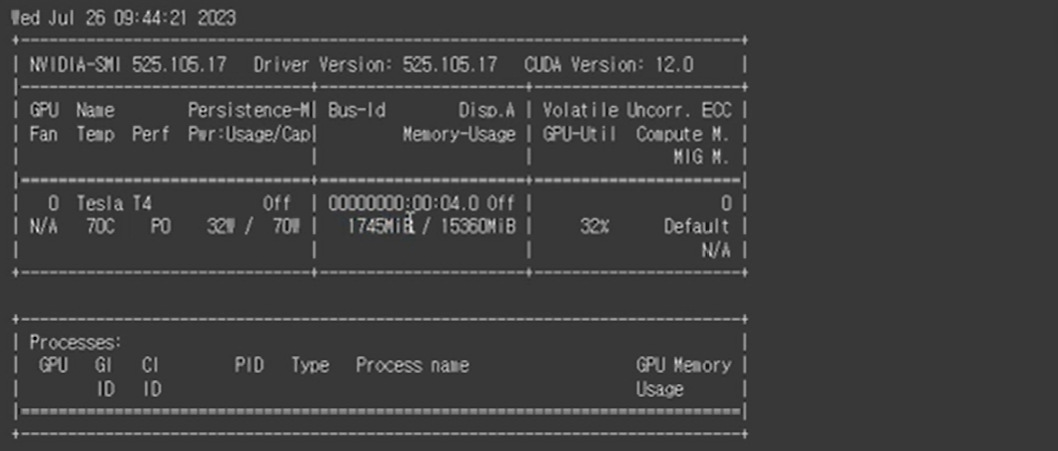

In [37]:
# test_tensor를 del 명령을 통해 'test_tensor' 객체를 삭제합니다.
del test_tensor

# GPU 메모리 캐시를 비웁니다.
torch.cuda.empty_cache()

In [38]:
# torch.cuda.empty_cache() 실행 후
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


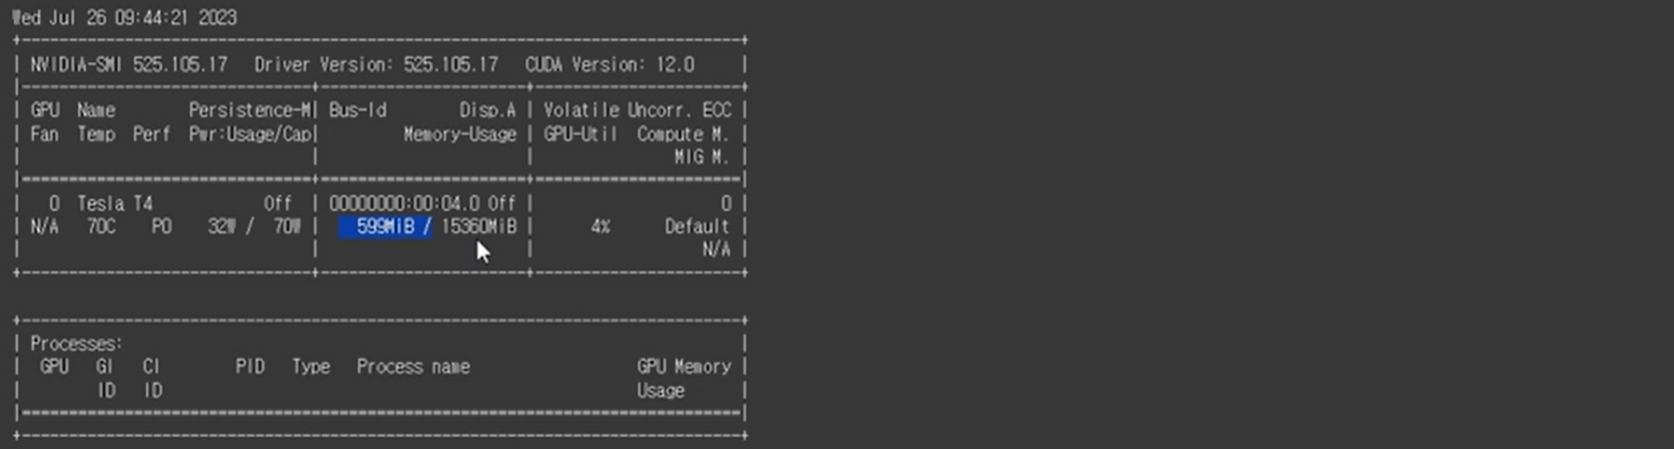

## `detach`, `cpu`
PyTorch의 tensor는 기본적으로 gradient를 계산하고 역전파를 위한 정보를 가지고 있습니다. 이는 GPU 메모리에 추가적인 부담을 주며, 이 tensor를 NumPy 배열로 변환하려고 하면 에러가 발생합니다.

이를 해결하기 위해 'detach()'를 호출하여 gradient를 기록하지 않아야 합니다. 또한, tensor가 GPU에 있을 경우, CPU로 옮긴 후에 NumPy 배열로 변환해야 합니다.


구글 검색 키워드: 에러 메세지


In [39]:
pred = torch.tensor([1., 0., 1.], requires_grad = True)
label = torch.tensor([1., 0., 0.], requires_grad = True)

pred = pred.numpy()
label = label.numpy()

accuracy_score(label, pred)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [40]:
# 일반적으로 scikit learn metric 등 numpy ndarray를 입력으로 받는 함수들을 사용하기 위해 모델에서 연산된 결과물을 변환해야 합니다.
# requires_grad와 cuda tensor로 변경합니다.
pred = torch.tensor([1., 0., 1.]).to(device)
label = torch.tensor([1., 0., 0.]).to(device)

pred = pred.numpy()
label = label.numpy()

accuracy_score(label, pred)

0.6666666666666666

In [41]:
# 올바르게 구현된 코드
pred = torch.tensor([1., 0., 1.], requires_grad = True).to(device)
label = torch.tensor([1., 0., 0.], requires_grad = True).to(device)

pred = pred.detach().cpu().numpy()
label = label.detach().cpu().numpy()

accuracy_score(label, pred)

0.6666666666666666

# 4.흔한 실수 사례

```
💡 목차 개요: 딥러닝 모델을 구현하며 흔히 실수하는 내용을 알아봅니다.
   이번 섹션에서 실수하는 사례들은 코드적인 오류가 존재하지는 않기 때문에 에러 메세지가 발생하지 않습니다.
   하지만 실수에 따라 모델의 성능에 치명적으로 영향을 미칠 수 있습니다.
```

## 실수 사례

흔히 실수하는 사례로는 크게 세 가지가 존재합니다.
1. **random seed를 고정하지 않고 하이퍼 파라미터 튜닝**: 딥러닝 모델의 결과는 초기화와 같은 random 요소에 크게 영향을 받습니다. 모델의 학습이 매번 동일한 조건에서 시작되도록 하기 위해, 실험의 재현성을 보장하는 데 중요한 역할을 하는 random seed를 설정해야 합니다.

2. **`optim.zero_grad()`를 하지 않는 경우**: PyTorch에서는 기본적으로 gradient가 누적되도록 설정되어 있습니다. 따라서 각 배치에서 역전파를 진행하기 전에 명시적으로 gradient를 0으로 설정하여 데이터가 누적되어 학습에 사용되지 않도록 해야 합니다.

3. **evaluation 단계에서 `model.eval()`을 하지 않은 경우**: BatchNorm이나 Dropout 같은 일부 레이어는 훈련 모드와 평가 모드에서 다르게 동작합니다. 딥러닝 모델을 구현하다 보면, 학습 코드와 평가 코드를 나누어 두는 경우가 일반적인데, 평가 코드에서 모델을 로드하기만 한다면 BatchNorm, Dropout 등의 일부 레이어는 정상적으로 작동하지 않습니다. 그래서 평가 시에는 `model.eval()`을 꼭 호출하여 평가 모드로 전환하는 것이 중요합니다.


In [42]:
# 3번 사례에서 dropout 레이어를 모델로 가정하고 실습합니다.
# dropout layer에서는 tensor의 output이 '0'로 설정되기 때문에, 평가 시 사용할 때는 dropout을 비활성화 해야 합니다.

model = nn.Dropout(0.5)

# 랜덤하게 생성한 tensor
input_tensor = torch.randn(5, 10)

# Dropout in Training Mode
model.train()
output_train = model(input_tensor)
print("Output in Training Mode: \n", output_train)

print("\n")
# Dropout in Evaluation Mode
model.eval()
output_eval = model(input_tensor)
print("Output in Evaluation Mode: \n", output_eval)

Output in Training Mode: 
 tensor([[ 0.0000,  1.5291, -0.4124, -1.7958,  1.8350, -0.0000,  2.5914,  0.0000,
          1.4516,  0.0000],
        [ 0.0000, -1.5262,  0.0000,  4.1146, -0.5330, -0.4722, -0.5829, -0.6634,
          0.3928, -0.0000],
        [ 2.6593,  0.9290, -3.5715,  0.0000,  0.0000, -0.0000, -0.0000,  0.5863,
         -0.1048, -0.0000],
        [-0.0000, -1.5972, -1.2655,  1.4121,  1.1273, -0.3788,  1.0531,  1.2727,
         -0.0000, -0.0000],
        [ 3.4691, -0.0000,  2.6392,  0.7037, -2.7013,  1.5460,  0.0000, -0.0000,
          1.0444, -0.9018]])


Output in Evaluation Mode: 
 tensor([[ 0.0908,  0.7646, -0.2062, -0.8979,  0.9175, -0.2486,  1.2957,  1.1506,
          0.7258,  1.5729],
        [ 1.8608, -0.7631,  0.2253,  2.0573, -0.2665, -0.2361, -0.2915, -0.3317,
          0.1964, -0.1745],
        [ 1.3296,  0.4645, -1.7858,  1.3218,  0.8220, -0.8963, -0.5816,  0.2931,
         -0.0524, -0.0627],
        [-1.0389, -0.7986, -0.6327,  0.7061,  0.5637, -0.1894,  0.526